# In part B , we will create some visualizations, an interactive map and dive into deep learning + natural language processing with the Airbnb 2020 Listings dataset of Seattle

In [1]:
#Standard libraries 
import numpy as nup
import pandas as pd 
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

import os 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#Interactive map libraries
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from branca.colormap import LinearColormap


#Plotly graphs libraries
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)


#Natural Language processing 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [2]:
#Loading the dataset
listings = pd.read_csv("E:/Coding/0.Additional Project/AirBnb/Seattle -2020/listings.csv", index_col= "id", encoding='latin1')
                                                                    #encoding='latin1' - convert string from UTF-8 to Latin-1
                                                                    #index_col="id" - to take "id"  as the row labels of the DataFrame
listings_details = pd.read_csv("E:/Coding/0.Additional Project/AirBnb/Seattle -2020/listings2.csv", index_col= "id", low_memory=False,encoding='latin1')
                                                                    #index_col="id" - to take "id"  as the row labels of the DataFrame


    

calendar = pd.read_csv("E:/Coding/0.Additional Project/AirBnb/Seattle -2020/calendar.csv", parse_dates=['date'], index_col=['listing_id'])
                                                                    #parse_dates: to transform the date type to the correct form that we want, this process takes very long time 4-5 minutes
                                                                    #index_col=''listing_id'' - to take 'listing_id''  as the row labels of the DataFrame
#reviews = pd.read_csv("E:/Coding/0.Additional Project/AirBnb/Seattle -2020/reviews.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("E:/Coding/0.Additional Project/AirBnb/Seattle -2020/reviews_details.csv", parse_dates=['date']) #, index_col=['id'], 
                                                                     #parse_dates: to transform the date type to the correct form that we want, this process takes very long time 4-5 minutes
                                                                    #index_col="id" - to take "id"  as the row labels of the DataFrame

In [3]:
print(listings.shape)

(7237, 14)


In [4]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [5]:
#Creating the target factors that are useful for the EDA
target_columns= ["property_type", "accommodates", "first_review", "review_scores_value","review_scores_cleanliness", 
                 "review_scores_location","review_scores_accuracy", "review_scores_communication","review_scores_checkin",
                 "review_scores_rating", "maximum_nights", "listing_url","host_is_superhost","host_about","host_response_time",
                 "host_response_rate", "street", "weekly_price","monthly_price", "market", ]
                                                #Creating a shell of columns that we want to target 
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
                                                #Use merge left to merge the two listings together so that we can get the dataset  
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7237 entries, 2318 to 43258878
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            7237 non-null   object 
 1   host_id                         7237 non-null   int64  
 2   host_name                       7237 non-null   object 
 3   neighbourhood                   7237 non-null   object 
 4   latitude                        7237 non-null   float64
 5   longitude                       7237 non-null   float64
 6   room_type                       7237 non-null   object 
 7   price                           7237 non-null   int64  
 8   minimum_nights                  7237 non-null   int64  
 9   number_of_reviews               7237 non-null   int64  
 10  last_review                     6309 non-null   object 
 11  reviews_per_month               6309 non-null   float64
 12  calculated_host_listings_co

In [6]:
#Showing the head of the dataframe that we will work with 
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))
                                                    #eliminate the % in the column and turn the whole column into normal numeric dataset
listings.head()

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
id,,,,,,,,,,,,,,,,,,,,,
2318,Casa Madrona - Urban Oasis 1 block from the park!,2536,Megan,Central Area,47.61082,-122.29082,Entire home/apt,296,7,32,...,1000,https://www.airbnb.com/rooms/2318,t,I welcome guests from all walks of life and ev...,within an hour,75.0,"Seattle, WA, United States",NaN,NaN,Seattle
6606,"Fab, private seattle urban cottage!",14942,Joyce,Other neighborhoods,47.65411,-122.33761,Entire home/apt,90,30,150,...,1125,https://www.airbnb.com/rooms/6606,f,I am a therapist/innkeeper.I know my city well...,within a day,100.0,"Seattle, WA, United States",$670.00,NaN,Seattle
9419,Glorious sun room w/ memory foambed,30559,Angielena,Other neighborhoods,47.55017,-122.31937,Private room,62,2,148,...,180,https://www.airbnb.com/rooms/9419,t,I am a visual artist who is the director of ...,within a few hours,90.0,"Seattle, WA, United States",$580.00,"$1,500.00",Seattle
9531,The Adorable Sweet Orange Craftsman,31481,Cassie,West Seattle,47.55539,-122.38474,Entire home/apt,165,3,40,...,730,https://www.airbnb.com/rooms/9531,t,The Sweet Orange reflects my passion and zest ...,within a few hours,100.0,"Seattle, WA, United States","$1,075.00","$3,000.00",Seattle
9534,The Coolest Tangerine Dream MIL!,31481,Cassie,West Seattle,47.55624,-122.38598,Entire home/apt,125,2,49,...,365,https://www.airbnb.com/rooms/9534,t,The Sweet Orange reflects my passion and zest ...,within a few hours,100.0,"Seattle, WA, United States",$825.00,"$2,500.00",Seattle


# I/ Exploratory data analysis- Data exploration

## 1) Neigbourhood 

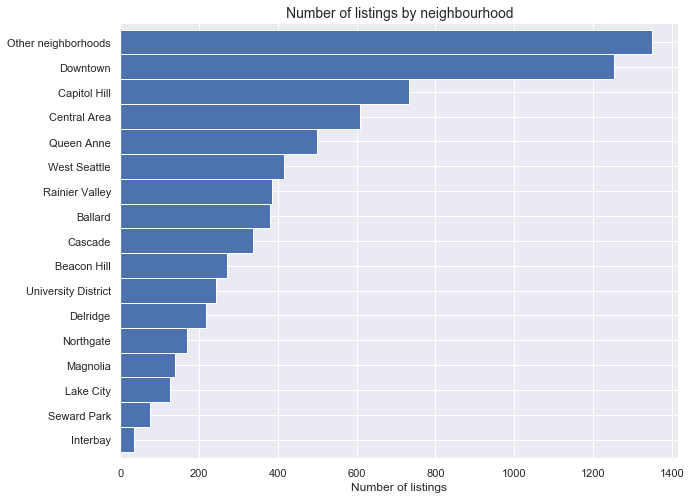

In [7]:
#Seeing which neighborhood has the highest number of listings
feq = listings['neighbourhood'].value_counts().sort_values(ascending=True)
feq.plot.barh(figsize=(10,8), color ='b', width= 1)
plt.title('Number of listings by neighbourhood', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.show()

In [8]:
#Interactive maps to see the figures of 2020 
lats2020 = listings['latitude'].tolist()
                        #tolist(): convert the series to a list
lons2020 =listings['longitude'].tolist()
locations = list(zip(lats2020, lons2020))

map1 = folium.Map(location=[47.606, -122.332], zoom_start=12.5)
                                #location=[47.6062, -122.3321] : is the latitude and longtitude of Seattle 
FastMarkerCluster(data=locations).add_to(map1)
map1

## 2) Room types, Property type,  & Number of people per booking

Room type

In [9]:
#Unique Check
listings.room_type.unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

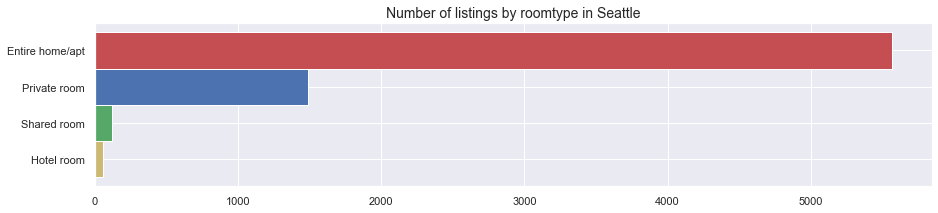

In [10]:
#Histogram 
freq = listings['room_type'].value_counts().sort_values(ascending=True)
freq.plot.barh(figsize =(15,3), width=1, color=['y','g','b','r'])
                                            #We give four different colours for our graphs
plt.title("Number of listings by roomtype in Seattle", fontsize=14)
plt.show()

Property type

In [11]:
#Unique Check
listings.property_type.unique()

array(['House', 'Guesthouse', 'Apartment', 'Guest suite', 'Condominium',
       'Townhouse', 'Bungalow', 'Cottage', 'Bed and breakfast', 'Loft',
       'Boat', 'Cabin', 'Houseboat', 'Other', 'Tiny house', 'Treehouse',
       'Hostel', 'Camper/RV', 'Yurt', 'Tent', 'Serviced apartment',
       'Aparthotel', 'Chalet', 'Villa', 'Boutique hotel', 'In-law',
       'Resort', 'Earth house', 'Dome house'], dtype=object)

In [12]:
#We want to Display the property types with at least 100 listings as there are too many different unique values 
#We will create a seperate columns 'total' to sort the data and then delete it once finished 
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
                #Returns a DataFrame having a new level of column labels whose inner-most level consists of the pivoted index labels.
                #To group the room_type together 
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
                #Create a column of to caculate the total
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
                #sort by ascending order to get the best and select only the groups of property types that have >=100 inputs 
prop = prop.drop(columns=['total'])
                #drop the 'Total' coumn once we are done 

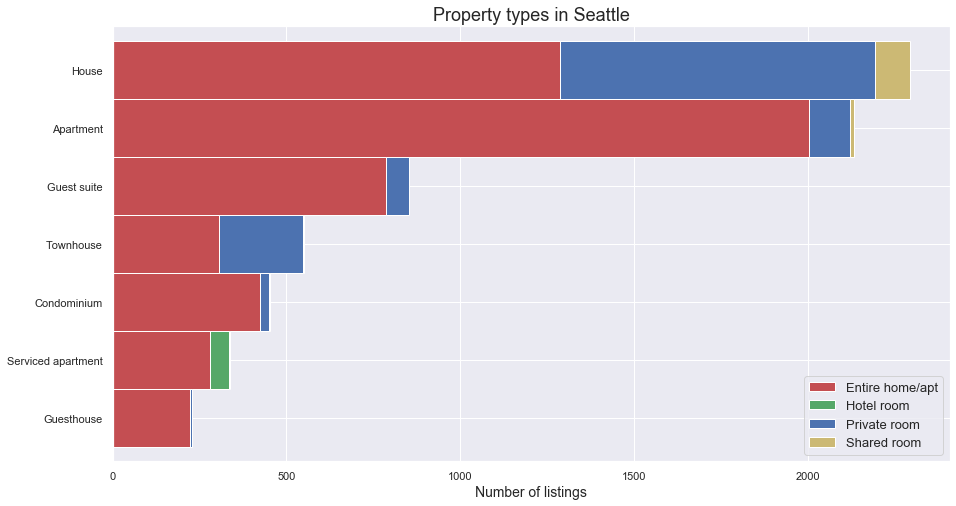

In [13]:
#Histogram 
prop.plot(kind='barh',stacked=True, color=['r','g','b','y'],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
                                        #Trying to match with the color pallete that we have above 
plt.title('Property types in Seattle', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

Number of people per booking

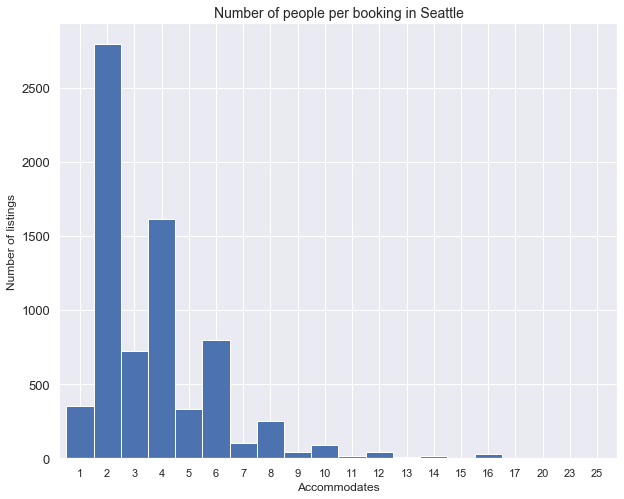

In [14]:
feq = listings['accommodates'].value_counts().sort_index()
feq.plot.bar(figsize=(10,8), width=1, rot=0)
plt.title('Number of people per booking in Seattle', fontsize=14)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Accommodates', fontsize=12)
plt.show()

# II/ Advice to the Mayor of Seattle

## 1) Findings possibly illegal hotels

It is no secret that Airbnb has been accused for escalating the Affordable-Housing crisis in many cities across the world.  (https://www.governing.com/columns/public-money/gov-airbnb-affordable-housing.html). To prevent this from happening, Seattle's Department of Finance and Administrative Services forced every Airbnb hosts to get short-term rental operator’s licenses before operating as up Demceber 2019 (https://www.airbnb.com/help/article/869/seattle-wa). The lisence is about $75/ unit, renewed annually. Each short tearm contracts allows you to operate up to two dwlling units: 

            -Primary residence: "person’s usual place of return for housing as documented by motor vehicle registration, driver’s license, voter registration, or other such evidence.” 
            -Secondary residence: vacation home or second home 

However, the guideline is not enforced upon all the listings, there are limited exceptions to  the maximum number of units, including some exceptions for short-term rentals legally operated before Sept. 30, 2017. It is noted that the if you operate a hotel or motel on Airbnb, the host will not required to register for a shorterm rental permit, but do need to claim a formal exemption. 

In [15]:
#Check the number 
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name','street']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

,host_id,host_name,street,private_rooms
715,75343272,Dario,"Seattle, WA, United States",56
559,39834464,Vera,"Seattle, WA, United States",21
309,13701143,Seyed,"Seattle, WA, United States",12
297,12796487,Shannon,"Seattle, WA, United States",11
712,73484597,Lee,"Seattle, WA, United States",11


In [40]:
#We check the suspicious host Dario (1) why they have so many rooms and are they on the same building or not  
suspicious_host1 = private[private['host_id']== 75343272]
suspicious_host1 = suspicious_host1[['name','host_id', 'host_name', 'latitude', 'longitude']]
suspicious_host1.index.name = "listing_id"
suspicious_host1.head(20)

,name,host_id,host_name,latitude,longitude
listing_id,,,,,
34471035,French Connection 10 min walk to downtown,75343272,Dario,47.61548,-122.31547
34472109,Mandala Room 10 min walk to downtown,75343272,Dario,47.61650,-122.31608
34472736,The London Booth Room 10 min walk to downtown,75343272,Dario,47.61538,-122.31614
34473290,Cornflower Blue Bedroom 10mins walk to Downtown,75343272,Dario,47.61485,-122.31468
34474146,The Damascus Bedroom in Capitol Hill,75343272,Dario,47.61478,-122.31702
34474732,Paris in Pink Bedroom 10 min walk to downtown,75343272,Dario,47.61474,-122.31678
34475082,Nature's Room on Capitol Hill,75343272,Dario,47.61473,-122.31697
34475312,Yellow Pear Room 10 mins walk to downtown,75343272,Dario,47.61515,-122.31484
34475996,Happy Buddha Room 10 min walk to downtown,75343272,Dario,47.61617,-122.31622


Dario's properties can be categorized into 4 different groups according to his listings's names

    -10 min drive to downtown
    -5 min drive from Downtown
    -3 blocks to Seattle Center
    - private rooms 
    
Nevertheless, when you check the actual Longtitude and Lactitude themselves, they are highly similar to each other with slight difference. Pictures of rooms, facilities on Airbnb's listings cannot be distinguished from one to another. From a respective point of view, it seems like he is running a boutique hotel but classify as shortterm rental's license, which was designed specially for Airbnb, from the city center.  
https://www.airbnb.com/rooms/43434896?source_impression_id=p3_1591925255_WCNBoABCysSUpwiS&guests=1&adults=1
https://www.airbnb.com/rooms/43434358?source_impression_id=p3_1591925546_k3B0Utbbpxlwc1cF&guests=1&adults=1

From the aforementioned guideline, Dario could likely be running a hotel or belong to the 'exemption' group that signed up before Sept. 30, 2017. If not, Airbnb or the city council should have a look into the situation of Dario to investigate if he is violating the rule or not 

## 2) Unwanted effects of professional hosts 

In [17]:
#Demonstrate the distribution of listing
freq1 = listings.groupby(['host_id']).size().reset_index(name ='num_host_listings')
host_prop = freq1.groupby(['num_host_listings']).size().reset_index(name ='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

num_host_listings,1,2,3,4,5,6,7,8,9,10,...,49,51,52,57,59,71,85,133,243,312
count,3394,470,147,58,27,20,17,7,6,6,...,1,1,1,1,1,1,1,1,1,1


In [18]:
#Displaying the hosts with more than 15 listings
freq = listings.groupby(['host_id', 'host_name', 'host_about']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'], ascending=False)
freq = freq[freq['num_host_listings'] >= 15]
freq

,host_id,host_name,host_about,num_host_listings
936,8534462,Corp Condos & Apts,We are a passionate team running a modern tech...,312
2054,48005494,Zeus,Zeus is reinventing corporate housing. We do t...,243
2824,229095817,Loftium,"Stay where it counts. When you book a Loftium,...",133
2359,82961680,Addison,I am an experienced Domicile hostess and I hav...,71
2092,50550045,Mike,We have been delighted to host guests since A...,59
210,1243056,Andy,Grokhome is all about building fun and creativ...,57
28,74305,Seattle Oasis,This endeavor started when Darik and Sally pur...,51
446,3074414,Melissa,Used to be a professor (Ph.D. in Political Eco...,49
563,4124418,Ashish,Renting Furnished apartments is what I do for ...,47
2613,140236800,TurnKey Vacation Rentals,"From all of us at TurnKey Vacation Rentals, we...",42


#The link of host name to demonstrate the professionalism 
'Corp Condos & Apts': Hostname was registered as 'Corp Condos & Apts' but the whole things are opeareted by Barsala company (https://barsala.com/) at this point:
https://www.airbnb.com/rooms/22210651?source_impression_id=p3_1591917765_ADRO9QNagbRFKU4q&guests=1&adults=1
https://www.airbnb.com/rooms/32670128?source_impression_id=p3_1591919264_zliA8Ul0jdp19VJx&guests=1&adults=1
host_about section of 'Corp Condos & Apts': "We are a passionate team running a modern tech-enabled corp housing co that believes nicely furnished high end homes should be consistent, affordable and easy to book." 

While if you look at the website of Balsala, they are a seperate app, and there is not much information about Barsala link compared to the other leasiting company : https://barsala.com/

--------------------------------------------------
'Zeus': https://zeusliving.com/
host_about section of 'Zeus': "Zeus is reinventing corporate housing. We do this by providing a unique, hassle-free, and high-quality housing experience in each of our 1,400+ homes throughout the San Francisco Bay Area, Los Angeles, Washington" 
Zeus has become a permanent partner with Zeus "As Airbnb  absorbs more and more of the demand for housing, it’s exploring how to monetize opportunities beyond vacation rentals. A marketplace for longer-term corporate housing could be a huge business, but rather than build that itself, Airbnb is making a strategic investment in one of the market leaders called Zeus Living" Airbnb and Zeus is making business conenction with each others site. " https://techcrunch.com/2019/12/09/airbnb-zeus/

--------------------------------------------------
'Loftium' :https://jobs.lever.co/loftium
host_about section of 'Loftium':"Stay where it counts. When you book a Loftium, you're contributing to the local community. Each Loftium is home to a local resident who hosts and lives right on-site, making sure your experience is a delightful one. All spaces are designed with your comfort in mind! We've made check-in and communication a breeze, and each home provides a beautiful and cozy place to rest your head during your travels. Every Loftium home and host is unique, and you'll always get a true neighborhood experience during your stay. Visit a new community and book a Loftium in any of our cities: Seattle, Portland, Denver, San Diego, Phoenix, Chicago, Atlanta, Dallas, Charlotte, or Orlando. We can't wait for you to visit!"

From renting room solely with Airbnb, the founders decided to build up their own property renting app to rivals and partner with Airbnb at the same time. Their business approach is to give rediculous discount to potential renter/buyer at pricey area if they agree to become host for Airbnb.  Hannah Exner (left) and Sam Joselyn scored a magnificent apartment at the Westlake for 1000USD/month at Westlake neighborhood where prices reach >1500USD/month: https://www.geekwire.com/2019/loftium-pivots-real-estate-biz-now-offers-discounts-apartment-tenants-rent-rooms-airbnb/

# III/ Advice to the tourists 

## 1) Per neigbourhood's Average daily price , Review score and Safety index

<function matplotlib.pyplot.show(*args, **kw)>

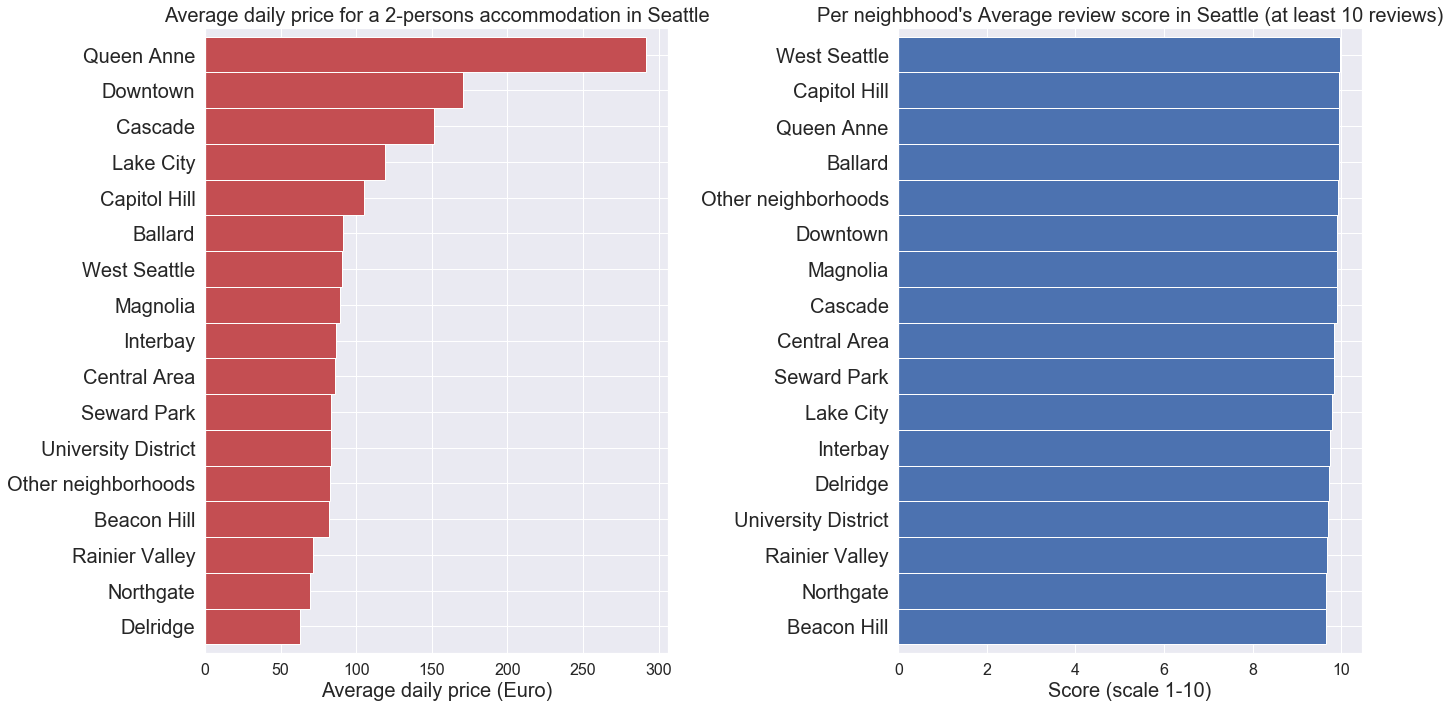

In [19]:
#Histogram of Average daily price & Average review score by neighbourhood
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)


ax1 = fig.add_subplot(121)
feq = listings[listings['accommodates']==2]
                                         #take the property that accommodates 2 people only
feq1 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
                                         #groupby the 'neigborhood' then find the mean of the price and sort the value from ascedding order 

ax1=feq1.plot.barh(color='r', width=1)
plt.title("Average daily price for a 2-persons accommodation in Seattle", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=20)
plt.ylabel("")



ax2 = fig.add_subplot(122)
feq = listings[listings['number_of_reviews']>=10]
                                        #Take the lsitings with more than 10 reviews only 
feq2 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
                                        #groupby the 'neigborhood' then find the mean of the price and sort the value from ascedding order 

ax2=feq2.plot.barh(color='b', width=1)
plt.title("Per neighbhood's Average review score in Seattle (at least 10 reviews)", fontsize=20)
plt.xlabel('Score (scale 1-10)', fontsize=20)
plt.ylabel("")

plt.tight_layout()
plt.show

## 2) How to use Review Scores 

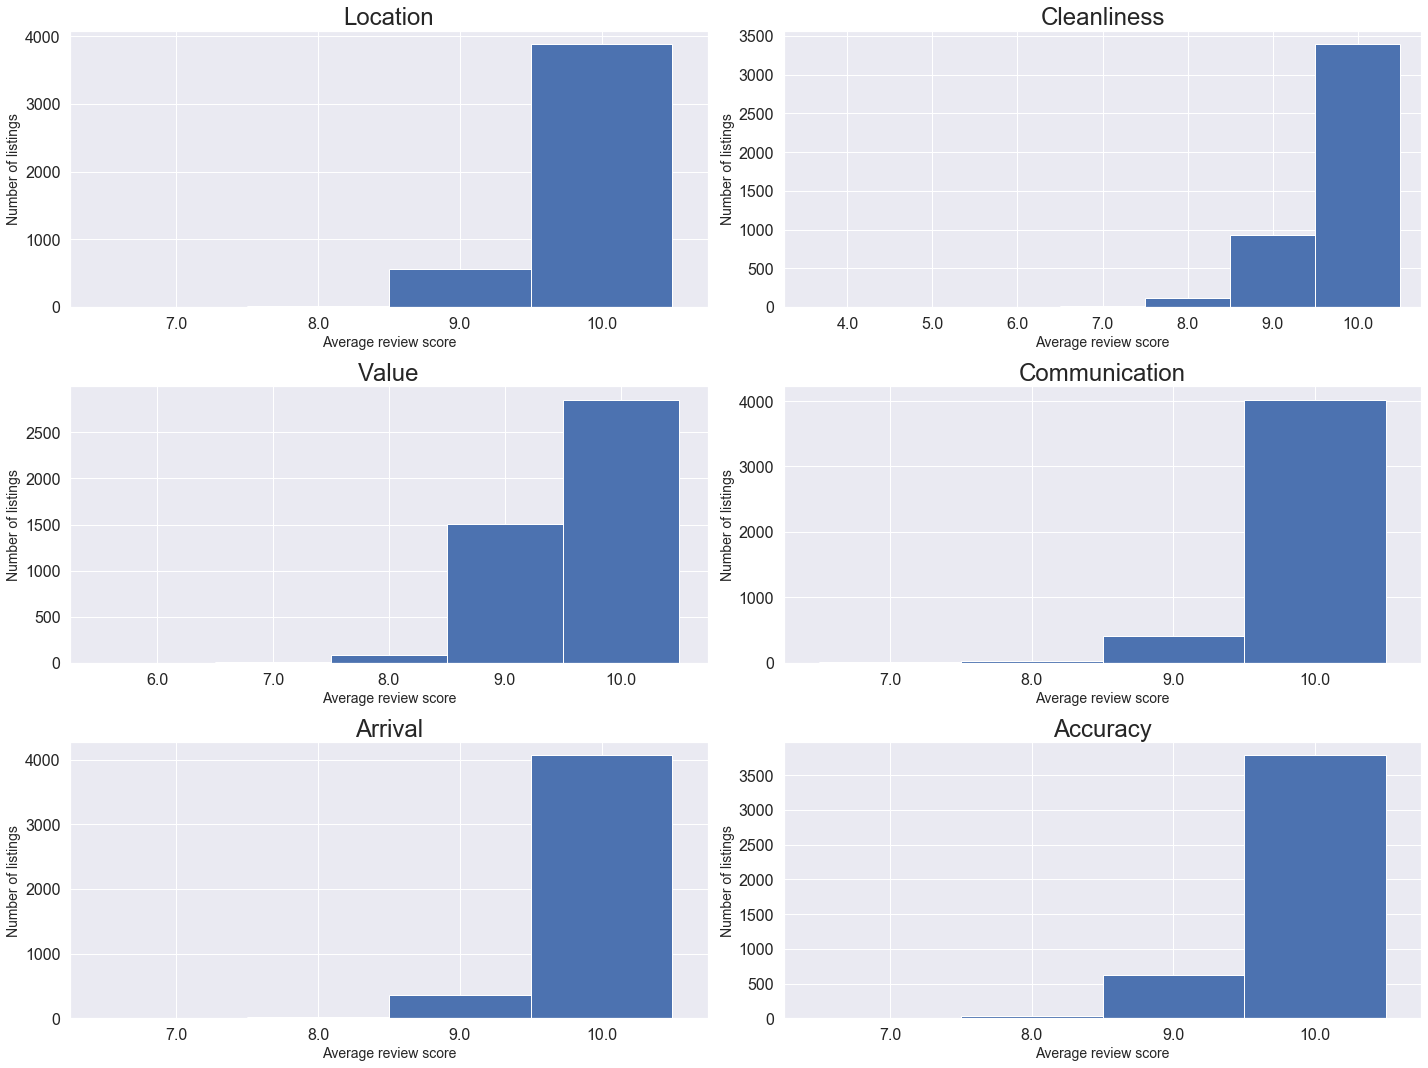

In [20]:
#Histogram of all the Reviews attributions
listings10 = listings[listings['number_of_reviews']>=10]

fig = plt.figure(figsize=(20,15))
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

#Location 
ax1 = fig.add_subplot(321)
feq=listings10['review_scores_location'].value_counts().sort_index()
ax1=feq.plot.bar(color='b', width=1, rot=0)
#ax1.tick_params(axis = 'both', labelsize = 16)
plt.title("Location", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

#Cleanliness 
ax2 = fig.add_subplot(322)
feq=listings10['review_scores_cleanliness'].value_counts().sort_index()
ax2=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Cleanliness", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

#ReviewScores value
ax3 = fig.add_subplot(323)
feq=listings10['review_scores_value'].value_counts().sort_index()
ax3=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Value", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

#Communication
ax4 = fig.add_subplot(324)
feq=listings10['review_scores_communication'].value_counts().sort_index()
ax4=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Communication", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

#Checkin
ax5 = fig.add_subplot(325)
feq=listings10['review_scores_checkin'].value_counts().sort_index()
ax5=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Arrival", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

#Accuracy
ax6 = fig.add_subplot(326)
feq=listings10['review_scores_accuracy'].value_counts().sort_index()
ax6=feq.plot.bar(color='b', width=1, rot=0)
plt.title("Accuracy", fontsize=24)
plt.ylabel('Number of listings', fontsize=14)
plt.xlabel('Average review score', fontsize=14)

plt.tight_layout()
plt.show()

## 3) Finding a good host 

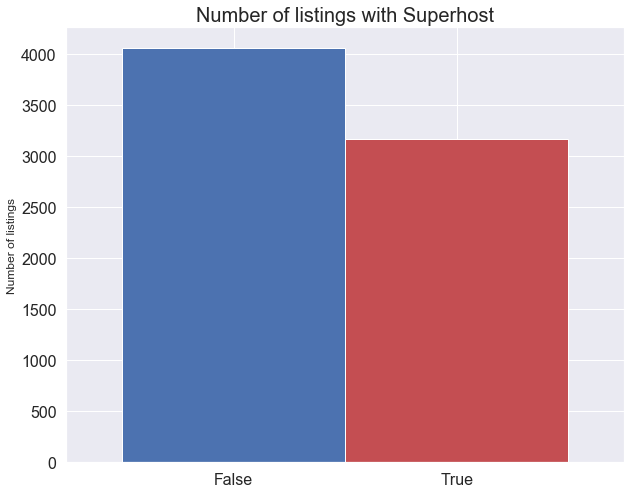

In [21]:
#Histogram of number of listings with superhosts 
listings.host_is_superhost = listings.host_is_superhost.replace({"t": "True", "f": "False"})
                                        #Replace all the columns to replace the 't' with 'True' and 'f' with 'False'
    
feq=listings['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), color=['b','r'], width=1, rot=0)
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.show()

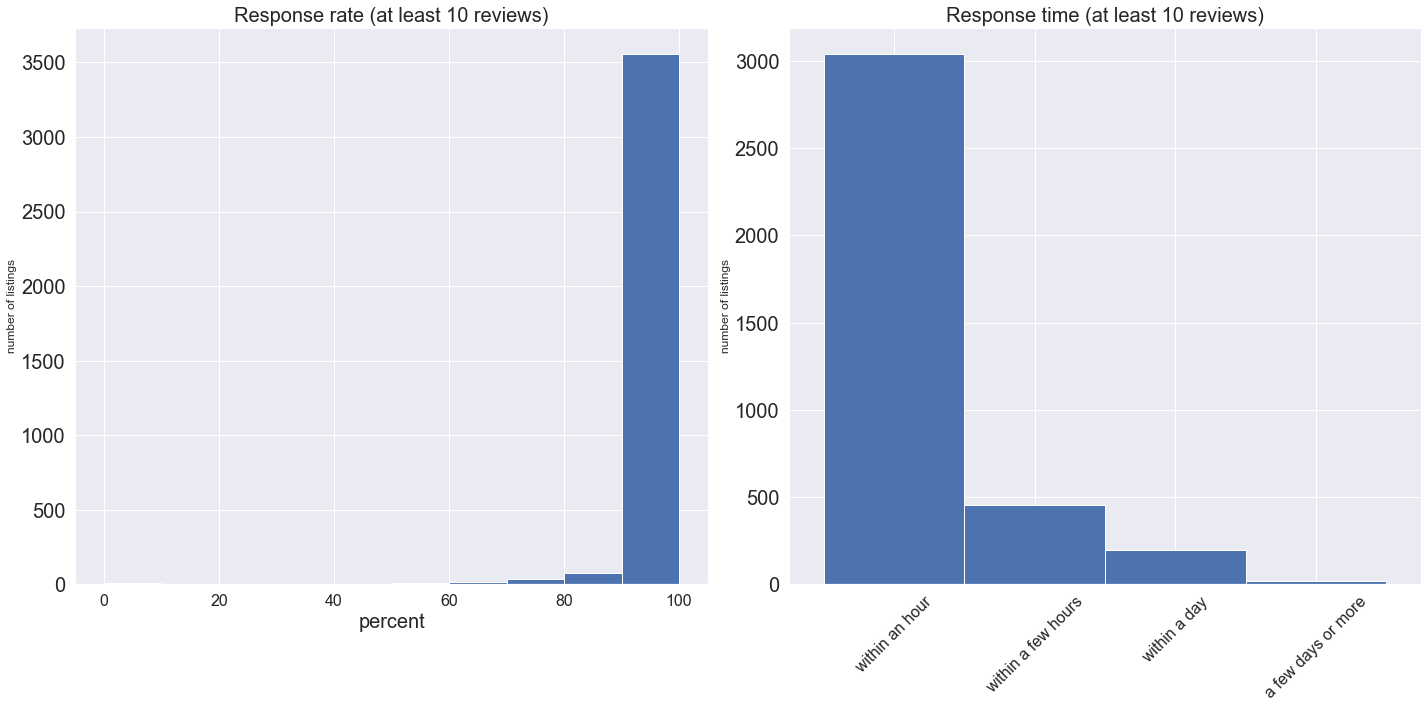

In [22]:
#Histogram of Response rate & Response Time
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

#Reponse Rate
ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
ax1= plt.hist(feq1)
plt.title("Response rate (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")
plt.xlabel("percent", fontsize=20)

#Reponse Time
ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='b', width=1, rot=45)
plt.title("Response time (at least 10 reviews)", fontsize=20)
plt.ylabel("number of listings")

plt.tight_layout()
plt.show()

## 4) Availability and Average price overtime 

In [23]:
#Data reprocessing before running everything
calendar.price = calendar.price.str.replace(",","")
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$'))
calendar = calendar[calendar.date > '2020-04-23']

In [24]:
print(calendar.shape)

(1045701, 3)


In [25]:
#Merge the calender with listings['accommodates'] on the shared columns called listings_id on the left
listings.index.name = "listing_id"
                                    #Create an index table with the name 'list_id'
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

,date,available,price,accommodates
listing_id,,,,
14373797,2020-10-02,t,105.0,2
13508899,2021-01-17,f,150.0,4
5785382,2020-05-15,t,999.0,3
143704,2021-01-24,t,80.0,3
7235573,2021-04-14,t,130.0,2
10569919,2021-02-25,t,299.0,8
14716424,2021-01-11,f,475.0,10
4681687,2020-10-28,f,75.0,2
17575412,2020-12-30,t,119.0,3


In [26]:
#Intereactive map of the number of listings available by date
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')

sum_available.iplot(y='available', mode = 'lines', xTitle = 'Date', yTitle = 'number of listings available',\
                   text='weekday', title = 'Number of listings available by date in Seattle')

In [27]:
#Intereactive map of average rate available by date
import numpy as np
average_price = calendar[(calendar.available == "t") & (calendar.accommodates == 2)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

average_price.iplot(y='price', mode='lines', xTitle='Date', yTitle='Price',
    text='weekday', title='Average price of available 2 persons accommodation by date in Seattle')

# IV/ Text Mining and review comments 

In [28]:
reviews_details.shape

(398157, 6)

In [29]:
#Create the list of review_details and all the necessary information
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
                                                #Merge the listings with the reviews_details on the left with listings_id as the shared
reviews_details = reviews_details.set_index('id')
                                                #set_index as "id"
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
                                                #These are the columns that we will be using in this part 
reviews_details.head()

,listing_id,name,host_id,host_name,date,reviewer_id,reviewer_name,comments
id,,,,,,,,
146,2318,Casa Madrona - Urban Oasis 1 block from the park!,2536,Megan,2008-09-15,2451,Kevin,1000 times better than staying at a hotel.
126302712,2318,Casa Madrona - Urban Oasis 1 block from the park!,2536,Megan,2017-01-10,12332845,Jessica,"Our family (two couples, a two year old and an..."
140977084,2318,Casa Madrona - Urban Oasis 1 block from the park!,2536,Megan,2017-04-01,4789466,Ivan,Top of the list locations we have stayed at! T...
147262504,2318,Casa Madrona - Urban Oasis 1 block from the park!,2536,Megan,2017-04-25,55817131,Mike,"SUCH an awesome place. Very clean, quiet and s..."
161806368,2318,Casa Madrona - Urban Oasis 1 block from the park!,2536,Megan,2017-06-18,113604590,Pete,We flew quite a distance to be at our only dau...


In [30]:
#Get the 5 most popular hosts with the greatest number of reviews, to see if they are the same with hosts that have the highest number of listinsgs above 
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
                                                #Group by the host_id , host_name and then sort the value to
host_reviews.head()

,,number_of_reviews
host_id,host_name,
229095817,Loftium,4181
20493911,Kevin,2306
15984289,Julian,2132
74305,Seattle Oasis,2124
5325329,Blair,2081


In [31]:
#Check the details of some of the first review 
reviews_details.comments.head()

id
146                1000 times better than staying at a hotel. 
126302712    Our family (two couples, a two year old and an...
140977084    Top of the list locations we have stayed at! T...
147262504    SUCH an awesome place. Very clean, quiet and s...
161806368    We flew quite a distance to be at our only dau...
Name: comments, dtype: object

In [32]:
#Print comment with numbers and windows line break
reviews_details.comments.values[1]
                            #Because the comment index0 is very short, we go with the index1

'Our family (two couples, a two year old and an infant) had an incredible stay at Casa Madrona. We have rented air bnb properties around the world, I can honestly say that this the most beautiful and comfortable home we have had the chance to visit. The photos do not do it justice. The house has been recently renovated with lovely touches like window seats throughout, a truly cozy gas fireplace and a gorgeous open kitchen with bamboo counters. The kitchen is fully equipped for those who like to cook—cuisinart, high quality pots and pans, multiple tea pots, etc.  The home was immaculate on arrival, and furnished with lovely art pieces as well as children’s toys that delighted our two year old. There were so many thoughtful touches that it felt like we were staying in the home of a friend (and one with very good taste), rather than a rental property.\n\nThe owners were instantly accessible, kind and in no way intrusive. Megan greeted us on arrival and helped us learn our way around the h

In [33]:
#Preprocessing of the data  
reviews_details = reviews_details[reviews_details['comments'].notnull()]
                                        #Take out empty comments
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+','')
                                        #remove numbers 
reviews_details['comments'] = reviews_details['comments'].str.lower()
                                        #lowercase
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n',"")
                                        #remove windows new line
stop_english=stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_e1949nglish)]))
                                        #remove all the stop words with nltk library
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
                                        #remove all punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')
                                        #replace x spaces by one space 


    
reviews_details['comments'].values[1]
                                        #print the comment index1 one more time 

'family two couples two year old infant incredible stay casa madrona rented air bnb properties around world honestly say beautiful comfortable home chance visit photos justice house recently renovated lovely touches like window seats throughout truly cozy gas fireplace gorgeous open kitchen bamboo counters kitchen fully equipped like cook cuisinart high quality pots pans multiple tea pots etc home immaculate arrival furnished lovely art pieces well children s toys delighted two year old many thoughtful touches felt like staying home friend and one good taste rather rental property owners instantly accessible kind way intrusive megan greeted us arrival helped us learn way around house knew would visiting newborn kindly set one bedroom nursery complete mobile daughter made sweet antique rocking chair lovely touch location ideal us a quick drive uber bus ride cap hill downtown one block walk playground shops cafes much enjoyed learning way around center madrona much offer took walks lake 

In [34]:
#Check how many different host names we have
host_names = reviews_details[['host_name']].drop_duplicates()
host_names = host_names.host_name.str.lower().tolist()

# reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
#                                                       if i not in (host_names)]))

len(host_names)

1949

In [35]:
#Top 10 common words in the comments with CountVectorizer()
texts= reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)


,words,counts
168,great,254121
179,place,226735
11,stay,196552
106,location,137181
148,seattle,129258
180,clean,124908
90,would,97765
23,comfortable,85830
376,nice,81972
285,space,73869


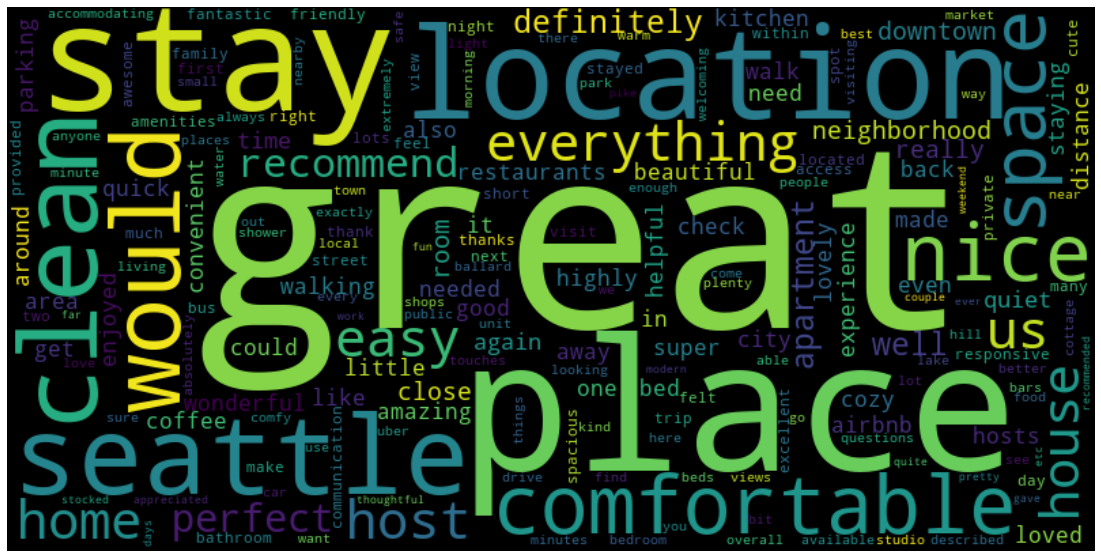

In [36]:
#Create the word cloud from the file we have 
cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()